In [ ]:
        # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Problem i have faced : 
 **1 Some image path in the csv aren't actually containing the true image path , That error leads to another df i have made 
    out of the folder structure
    Also The paths are windows and i am working in kaggle**
    
    

In [1]:
import torch 
import os 
from pathlib import Path
from torchvision.transforms import v2
from PIL import Image 
import pandas as pd 
from torch.utils.data import DataLoader , Dataset , random_split
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("/kaggle/input/massive-skin-disease-balanced-dataset/balanced_dataset.csv")
df.sample(10)

,image_path,category
50573,D:/python files/datasets/Dermabot/balanced_dat...,Cellulitis Impetigo And Other Bacterial Infect...
112893,D:/python files/datasets/Dermabot/balanced_dat...,Lupus And Other Connective Tissue Diseases
19050,D:/python files/datasets/Dermabot/balanced_dat...,Atopic Dermatitis Photos
220545,D:/python files/datasets/Dermabot/balanced_dat...,Vasculitis Photos
112590,D:/python files/datasets/Dermabot/balanced_dat...,Lupus And Other Connective Tissue Diseases
29074,D:/python files/datasets/Dermabot/balanced_dat...,Ba Impetigo
222448,D:/python files/datasets/Dermabot/balanced_dat...,Vasculitis Photos
37441,D:/python files/datasets/Dermabot/balanced_dat...,Benign
126069,D:/python files/datasets/Dermabot/balanced_dat...,Melanoma Skin Cancer Nevi And Moles
235666,D:/python files/datasets/Dermabot/balanced_dat...,Vi Shingles


In [3]:
df = pd.read_csv("/kaggle/input/massive-skin-disease-balanced-dataset/balanced_dataset.csv")
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: os.path.basename(str(x)))
df.head(10)

,image_path,category
0,balanced_dataset\Acne And Rosacea Photos\07Per...,Acne And Rosacea Photos
1,balanced_dataset\Acne And Rosacea Photos\07Rhi...,Acne And Rosacea Photos
2,balanced_dataset\Acne And Rosacea Photos\07rhn...,Acne And Rosacea Photos
3,balanced_dataset\Acne And Rosacea Photos\07Ros...,Acne And Rosacea Photos
4,balanced_dataset\Acne And Rosacea Photos\07Ros...,Acne And Rosacea Photos
5,balanced_dataset\Acne And Rosacea Photos\07Ros...,Acne And Rosacea Photos
6,balanced_dataset\Acne And Rosacea Photos\07seb...,Acne And Rosacea Photos
7,balanced_dataset\Acne And Rosacea Photos\07Ste...,Acne And Rosacea Photos
8,balanced_dataset\Acne And Rosacea Photos\07Ste...,Acne And Rosacea Photos
9,balanced_dataset\Acne And Rosacea Photos\07Vas...,Acne And Rosacea Photos


In [4]:
# Problem 1

# import os
# import pandas as pd

# ROOT_DIR = "/kaggle/input/massive-skin-disease-balanced-dataset/balanced_dataset/balanced_dataset"

# image_paths = []
# labels = []
# for root, dirs, files in os.walk(ROOT_DIR):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#             image_paths.append(os.path.join(root, file))
#             labels.append(os.path.basename(root))  # folder name as label

# # make dataframe
# df = pd.DataFrame({
#     "image_path": image_paths,
#     "label": labels
# })

# print("Total images:", len(df))
# print(df.head())


# ^TOO Much time consuming , i have found an alternative **GLOB**


# glob is implemented in C, much faster
import glob
import pandas as pd
import os

ROOT_DIR = "/kaggle/input/massive-skin-disease-balanced-dataset/balanced_dataset/balanced_dataset"


image_paths = glob.glob(ROOT_DIR + "/**/*.jpg", recursive=True)
image_paths += glob.glob(ROOT_DIR + "/**/*.png", recursive=True)
image_paths += glob.glob(ROOT_DIR + "/**/*.jpeg", recursive=True)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

print("Total images:", len(df))



Total images: 262874


In [5]:
df.head()

,image_path,label
0,/kaggle/input/massive-skin-disease-balanced-da...,Light Diseases And Disorders Of Pigmentation
1,/kaggle/input/massive-skin-disease-balanced-da...,Light Diseases And Disorders Of Pigmentation
2,/kaggle/input/massive-skin-disease-balanced-da...,Light Diseases And Disorders Of Pigmentation
3,/kaggle/input/massive-skin-disease-balanced-da...,Light Diseases And Disorders Of Pigmentation
4,/kaggle/input/massive-skin-disease-balanced-da...,Light Diseases And Disorders Of Pigmentation


In [6]:
df.label.unique()

array(['Light Diseases And Disorders Of Pigmentation',
       'Lupus And Other Connective Tissue Diseases',
       'Acne And Rosacea Photos', 'Systemic Disease', 'Rashes',
       'Poison Ivy Photos And Other Contact Dermatitis',
       'Fu Athlete Foot', 'Vascular Tumors', 'Ba Impetigo',
       'Urticaria Hives', 'Heathy', 'Vi Shingles',
       'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Benign',
       'Hair Loss Photos Alopecia And Other Hair Diseases',
       'Tinea Ringworm Candidiasis And Other Fungal Infections',
       'Pa Cutaneous Larva Migrans',
       'Psoriasis Pictures Lichen Planus And Related Diseases',
       'Melanoma Skin Cancer Nevi And Moles',
       'Nail Fungus And Other Nail Disease', 'Malignant',
       'Scabies Lyme Disease And Other Infestations And Bites',
       'Eczema Photos', 'Exanthems And Drug Eruptions',
       'Herpes Hpv And Other Stds Photos',
       'Seborrheic Keratoses And Other Benign Tumors',
       'Actinic Keratosis Basal Cell Carc

In [19]:
label_dict = {
    'Light Diseases And Disorders Of Pigmentation': 0,
    'Lupus And Other Connective Tissue Diseases': 1,
    'Rashes': 2,
    'Poison Ivy Photos And Other Contact Dermatitis': 3,
    'Ba Impetigo': 4,
    'Vi Shingles': 5,
    'Benign': 6,
    'Hair Loss Photos Alopecia And Other Hair Diseases': 7,
    'Tinea Ringworm Candidiasis And Other Fungal Infections': 8,
    'Pa Cutaneous Larva Migrans': 9,
    'Psoriasis Pictures Lichen Planus And Related Diseases': 10,
    'Melanoma Skin Cancer Nevi And Moles': 11,
    'Malignant': 12,
    'Scabies Lyme Disease And Other Infestations And Bites': 13,
    'Exanthems And Drug Eruptions': 14,
    'Herpes Hpv And Other Stds Photos': 15,
    'Seborrheic Keratoses And Other Benign Tumors': 16,
    'Actinic Keratosis Basal Cell Carcinoma And Other Malignant Lesions': 17,
    'Vasculitis Photos': 18,
    'Vi Chickenpox': 19,
    'Ba  Cellulitis': 20,
    'Fu Ringworm': 21,
    'Cellulitis Impetigo And Other Bacterial Infections': 22,
    'Fu Nail Fungus': 23,
    'Nail Fungus And Other Nail Disease': 24,
    'Fu Athlete Foot': 25,
    'Urticaria Hives': 26,
    'Vascular Tumors': 27,
    'Atopic Dermatitis Photos': 28,
    'Eczema Photos': 29,
    'Acne And Rosacea Photos': 30,
    'Warts Molluscum And Other Viral Infections': 31,
    'Heathy': 32,
    'Systemic Disease': 33,
    'Bullous Disease Photos': 34
}
label_dict

{'Light Diseases And Disorders Of Pigmentation': 0,
 'Lupus And Other Connective Tissue Diseases': 1,
 'Rashes': 2,
 'Poison Ivy Photos And Other Contact Dermatitis': 3,
 'Ba Impetigo': 4,
 'Vi Shingles': 5,
 'Benign': 6,
 'Hair Loss Photos Alopecia And Other Hair Diseases': 7,
 'Tinea Ringworm Candidiasis And Other Fungal Infections': 8,
 'Pa Cutaneous Larva Migrans': 9,
 'Psoriasis Pictures Lichen Planus And Related Diseases': 10,
 'Melanoma Skin Cancer Nevi And Moles': 11,
 'Malignant': 12,
 'Scabies Lyme Disease And Other Infestations And Bites': 13,
 'Exanthems And Drug Eruptions': 14,
 'Herpes Hpv And Other Stds Photos': 15,
 'Seborrheic Keratoses And Other Benign Tumors': 16,
 'Actinic Keratosis Basal Cell Carcinoma And Other Malignant Lesions': 17,
 'Vasculitis Photos': 18,
 'Vi Chickenpox': 19,
 'Ba  Cellulitis': 20,
 'Fu Ringworm': 21,
 'Cellulitis Impetigo And Other Bacterial Infections': 22,
 'Fu Nail Fungus': 23,
 'Nail Fungus And Other Nail Disease': 24,
 'Fu Athlete Foot

In [8]:
df.shape

(262874, 2)

In [9]:
# df["full_path"] = df["image_path"].apply(lambda x: os.path.join(IMAGES_DIRS, x))
# df = df[df["full_path"].apply(os.path.exists)].reset_index(drop=True)
# print("Valid images:", len(df))

In [10]:
df.shape

(262874, 2)

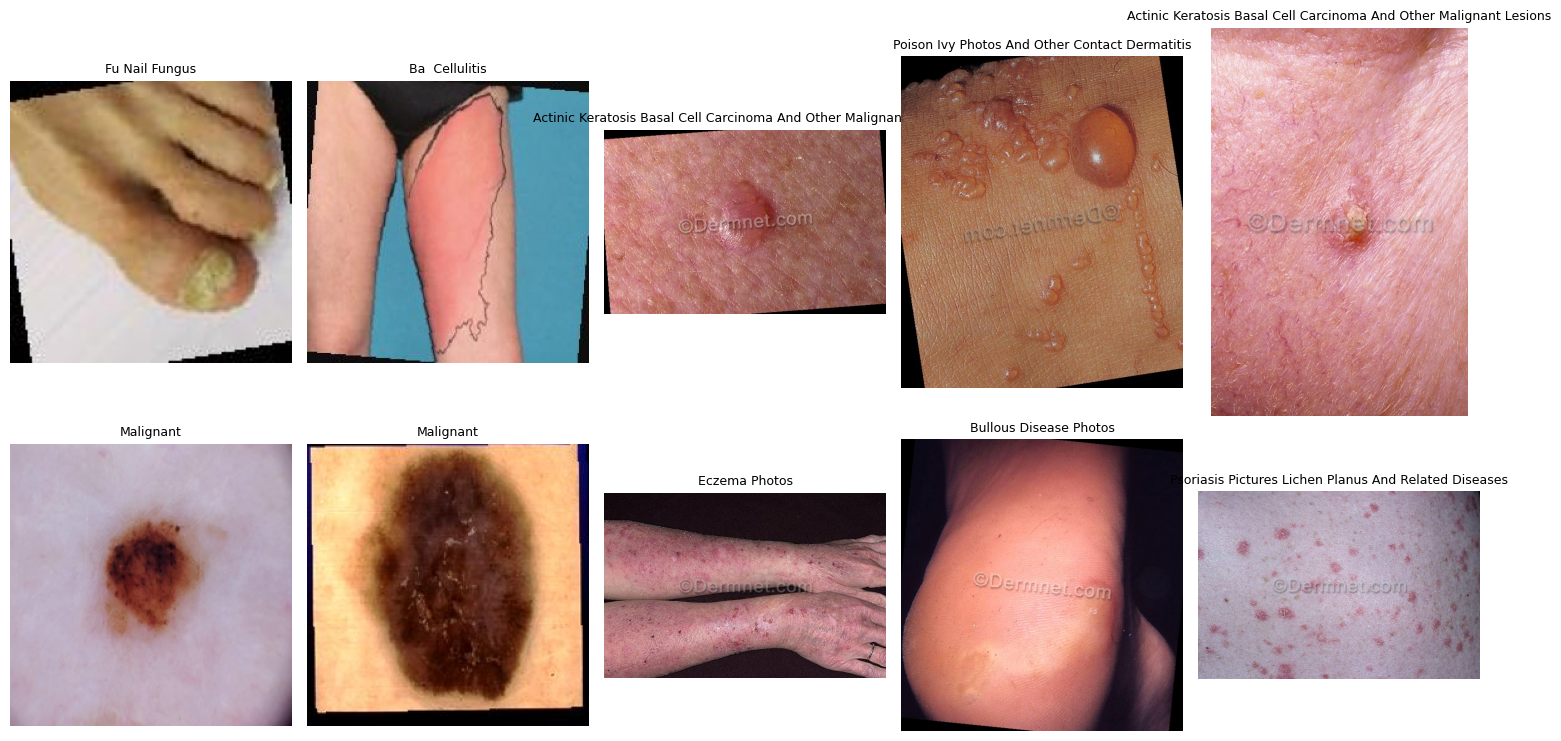

In [12]:
import numpy as np
import matplotlib.pyplot as plt 
idxs = np.random.choice(df.index, size=10, replace=False)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(idxs):
    img_path = df.loc[idx, "image_path"]
    img = Image.open(img_path).convert("RGB")
    
    plt.subplot(2, 5, i+1) 
    plt.imshow(img)
    plt.title(df.loc[idx, "label"], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [23]:
class SKINDISEASEDATASET(Dataset):
    def __init__(self, csv_file_or_df, transforms=None, label_dict=None):
        if isinstance(csv_file_or_df, str):
            self.data = pd.read_csv(csv_file_or_df)
        else:
            self.data = csv_file_or_df.reset_index(drop=True)

        self.transforms = transforms
        self.label_dict = label_dict  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = self.data.iloc[idx]["label"]

        # Use dict to encode label if provided
        if self.label_dict is not None:
            label = self.label_dict[label]

        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        return image, int(label)


In [14]:
## CSV FILE  as DF 
CSV_PATH = "skin_dataset.csv"
df.to_csv(CSV_PATH, index=False)


# a = SKINDISEASEDATASET(csv_file=CSV_PATH, transforms=train_transforms)

In [26]:
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224,224)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(0.3),
    v2.ColorJitter(contrast=0.3,brightness=0.2),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5])
])

val_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale= True),
    v2.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5])
])
test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5])
])




X = df.iloc[:,0].values   
y = df.iloc[:,1].values   # labels

X_train , X_temp , y_train , y_temp = train_test_split(X,
                                                      y,
                                                      test_size = 0.2,
                                                      stratify= y ,
                                                      random_state = 42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,         
    stratify=y_temp,
    random_state=42
)

print(f"X_train {X_train.shape} , X_val : {X_val.shape} , X_test : {X_test.shape}")

X_train (210299,) , X_val : (26287,) , X_test : (26288,)


In [31]:
train_df = pd.DataFrame({"image_path": X_train, "label": y_train})
val_df   = pd.DataFrame({"image_path": X_val,   "label": y_val})
test_df  = pd.DataFrame({"image_path": X_test,  "label": y_test})

train_df.to_csv("/kaggle/working/train.csv", index=False)
val_df.to_csv("/kaggle/working/val.csv", index=False)
test_df.to_csv("/kaggle/working/test.csv", index=False)

print("Saved train.csv, val.csv, test.csv in /kaggle/working/")
print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

Saved train.csv, val.csv, test.csv in /kaggle/working/
Train: (210299, 2), Val: (26287, 2), Test: (26288, 2)


In [32]:
train_dataset = SKINDISEASEDATASET(
    csv_file_or_df = train_df,
    transforms = train_transforms,
    label_dict = label_dict
)

val_dataset = SKINDISEASEDATASET(
    csv_file_or_df = val_df,
    transforms = val_transforms,
    label_dict = label_dict
)

test_dataset = SKINDISEASEDATASET(
    csv_file_or_df = test_df,
    transforms = test_transforms,
    label_dict = label_dict
)
train_dataset , test_dataset , val_dataset

(<__main__.SKINDISEASEDATASET at 0x7f9006519210>,
 <__main__.SKINDISEASEDATASET at 0x7f9006ca3a50>)

In [33]:
## DATALOADER 
train_dataloader = DataLoader(
    train_dataset ,
    batch_size = 32,
    shuffle = True,
    num_workers = 4
)
val_dataloader = DataLoader(
    val_dataset ,
    batch_size = 32,
    shuffle = False , 
    num_workers = 4
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

print(f"Train_dataloader length : {len(train_dataloader)}  | test_data_loader : {len(val_dataloader)} Test DataLoader length : {len(test_dataloader)}")

Train_dataloader length : 6572  | test_data_loader : 822 Test DataLoader length : 822


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# CNN MODEL WITHOUT PRETRAINED MODEL

**WITH PRETRAINED MODEL**